In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
from jax import random
import jax
from numpyro.infer import MCMC, NUTS, Predictive
from scipy.spatial.distance import cdist
import time
import seaborn as sns
from tinygp import kernels, GaussianProcess

jax.config.update("jax_enable_x64", True)

print(numpyro.__version__)

0.16.1


In [2]:
df = pd.read_csv("./NYC.csv")
df

,Age,RSL,AgeError,RSLError,Type
0,1857.5000,-0.382722,1.25000,0.020224,TG
1,1865.0000,-0.390889,2.50000,0.019072,TG
2,1875.0000,-0.375111,2.50000,0.038143,TG
3,1895.0000,-0.303651,2.50000,0.019982,TG
4,1905.0000,-0.290822,2.50000,0.029349,TG
...,...,...,...,...,...
86,676.1125,-1.635141,47.94375,0.091382,Core
87,652.0000,-1.662090,48.00000,0.095789,Core
88,629.5000,-1.709393,47.75000,0.119915,Core
89,603.0000,-1.718310,45.50000,0.084227,Core


# Normal GP


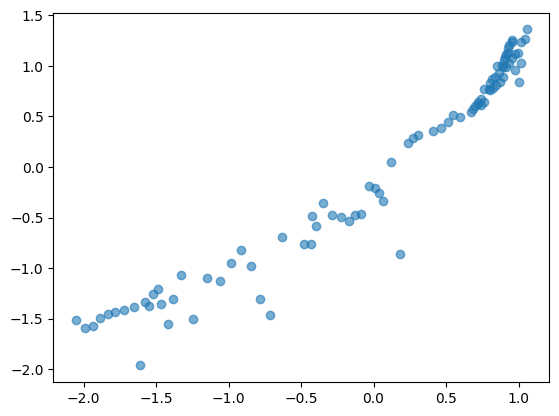

In [54]:
def standardize(x: pd.Series):
    return ((x - x.mean()) / x.std()).to_numpy()


x = (df["Age"] / 1000).pipe(standardize)
y = df["RSL"].pipe(standardize)
plt.scatter(x, y, alpha=0.6)

Let's look at sklearn GP first. Note, alpha can represent y uncertainty as seen [here](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#example-with-noisy-targets). Without that , it will try to fit every data point resulting in some messy visuals.


RBF(length_scale=0.0852)


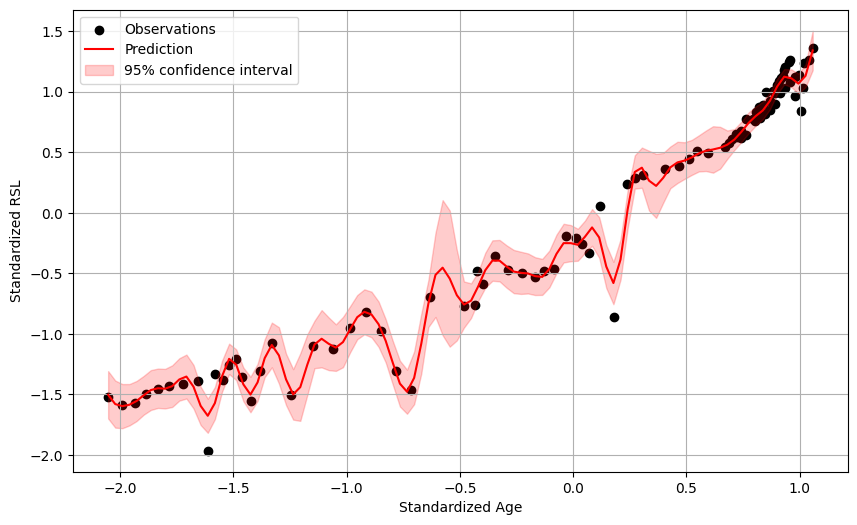

In [94]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

kernel = RBF(length_scale=0.5, length_scale_bounds=(1e-10, 1.0))
gp = GaussianProcessRegressor(
    kernel=kernel, n_restarts_optimizer=10, random_state=0, alpha=1e-2
)
gp.fit(x.reshape(-1, 1), y)

# Make predictions on a fine grid
X_test = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
y_pred, sigma = gp.predict(X_test, return_std=True)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c="black", label="Observations")
plt.plot(X_test, y_pred, "r-", label="Prediction")
plt.fill_between(
    X_test.ravel(),
    y_pred - 2 * sigma,
    y_pred + 2 * sigma,
    alpha=0.2,
    color="r",
    label="95% confidence interval",
)
plt.xlabel("Standardized Age")
plt.ylabel("Standardized RSL")
plt.legend()
plt.grid(True)
print(gp.kernel_)


Let's look at numpyro!


In [96]:
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        obs=Y,
    )


k = NUTS(model)
mcmc = MCMC(k, num_warmup=500, num_samples=2000)
mcmc.run(random.PRNGKey(0), X=x, Y=y)

sample: 100%|██████████| 2500/2500 [00:07<00:00, 331.80it/s, 7 steps of size 3.44e-01. acc. prob=0.94] 


<Axes: ylabel='Density'>

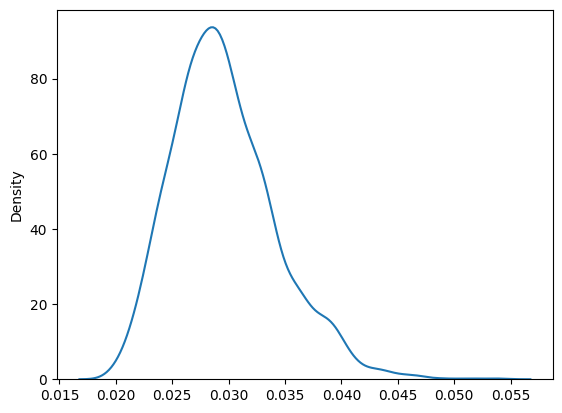

In [97]:
posterior = mcmc.get_samples()
sns.kdeplot(posterior["kernel_noise"])

In [98]:
def predict(rng_key, X, Y, X_test, var, length, noise, use_cholesky=True):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)

    # since K_xx is symmetric positive-definite, we can use the more efficient and
    # stable Cholesky decomposition instead of matrix inversion
    if use_cholesky:
        K_xx_cho = jax.scipy.linalg.cho_factor(k_XX)
        K = k_pp - jnp.matmul(k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, k_pX.T))
        mean = jnp.matmul(k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, Y))
    else:
        K_xx_inv = jnp.linalg.inv(k_XX)
        K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
        mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))

    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), 0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )

    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise


vmap_args = (
    random.split(random.PRNGKey(0), posterior["kernel_var"].shape[0]),
    posterior["kernel_var"],
    posterior["kernel_length"],
    posterior["kernel_noise"],
)
x_test = jnp.linspace(-2.5, 1.5, num=500)
means, predictions = jax.vmap(
    lambda rng_key, var, length, noise: predict(
        rng_key,
        x,
        y,
        x_test,
        var,
        length,
        noise,
        use_cholesky=True,
    )
)(*vmap_args)


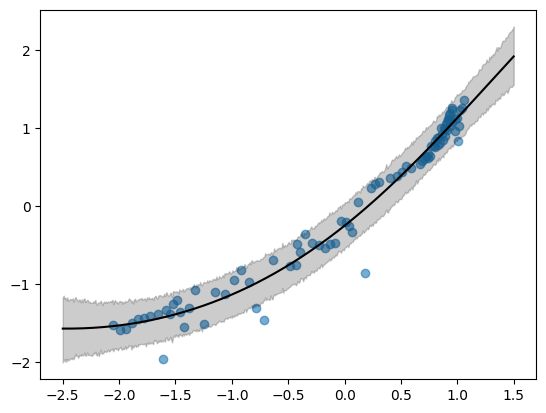

In [99]:
plt.scatter(x, y, alpha=0.6)
plt.plot(x_test, np.mean(means, axis=0), color="black")
hpdi = numpyro.diagnostics.hpdi(predictions, prob=0.9, axis=0)
plt.fill_between(x_test, hpdi[0], hpdi[1], alpha=0.2, color="black")

the noise parameter learnt by numpyro was higher than we set when playing with the sklearn GP, hence its overly smooth. we can see this by getting smooth result with sklearn by setting the `alpha` in the gpregressor to tht of the posterior mean for kernel noise.


# Response (y) noise


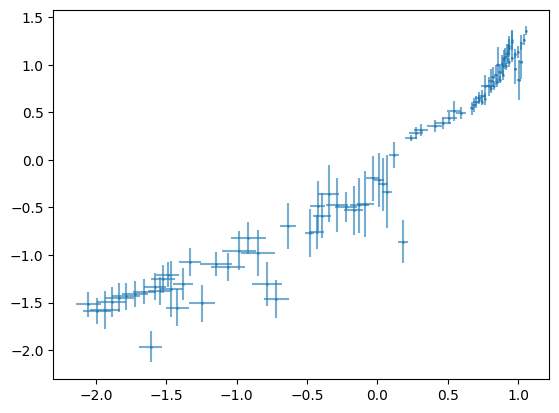

In [100]:
def standardize_with_uncertainties(x: pd.Series, x_error: pd.Series):
    """Standardize both values and their uncertainties"""
    x_std = x.std()
    x_mean = x.mean()

    # For the main values: (x - mean) / std
    x_standardized = ((x - x_mean) / x_std).to_numpy()

    # For uncertainties: only divide by std (don't subtract mean)
    x_error_standardized = (x_error / x_std).to_numpy()

    return x_standardized, x_error_standardized


x, x_err = standardize_with_uncertainties(df["Age"] / 1000, df["AgeError"] / 1000)
y, y_err = standardize_with_uncertainties(df["RSL"], df["RSLError"])

plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt="o", markersize=1, alpha=0.6);

RBF(length_scale=1.77)


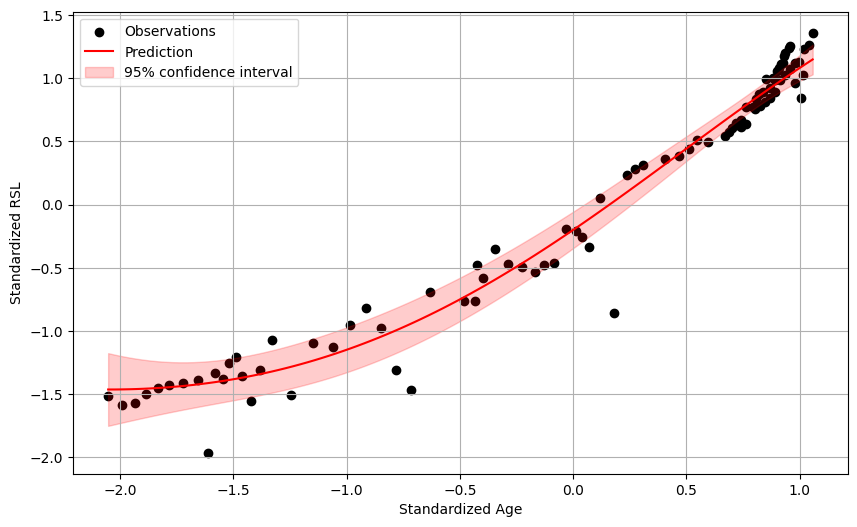

In [102]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

kernel = RBF(length_scale=0.5, length_scale_bounds=(1e-10, 10.0))
gp = GaussianProcessRegressor(
    kernel=kernel, n_restarts_optimizer=10, random_state=0, alpha=y_err
)
gp.fit(x.reshape(-1, 1), y)

# Make predictions on a fine grid
X_test = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
y_pred, sigma = gp.predict(X_test, return_std=True)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c="black", label="Observations")
plt.plot(X_test, y_pred, "r-", label="Prediction")
plt.fill_between(
    X_test.ravel(),
    y_pred - 2 * sigma,
    y_pred + 2 * sigma,
    alpha=0.2,
    color="r",
    label="95% confidence interval",
)
plt.xlabel("Standardized Age")
plt.ylabel("Standardized RSL")
plt.legend()
plt.grid(True)
print(gp.kernel_)


Again, with numpyro. This time, let's use tinyGP to make inference easier


In [188]:
# def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
#     deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
#     k = var * jnp.exp(-0.5 * deltaXsq)
#     if include_noise:
#         k += (noise + jitter) * jnp.eye(X.shape[0])
#     return k

true_t = np.linspace(x.min(), x.max(), 100)


def model(X, yerr, Y=None):
    mean = numpyro.sample("mean", dist.Normal(0.0, 5))
    jitter = numpyro.sample("jitter", dist.HalfNormal(5))
    sigma = numpyro.sample("sigma", dist.HalfNormal(5))
    tau = numpyro.sample("tau", dist.HalfNormal(5))
    kernel = sigma**2 * kernels.ExpSquared(tau)

    gp = GaussianProcess(kernel, X, diag=yerr**2 + jitter, mean=mean)
    numpyro.sample("gp", gp.numpyro_dist(), obs=Y)
    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, true_t).gp.loc)


k = NUTS(model)
mcmc = MCMC(k, num_warmup=500, num_samples=2000)
mcmc.run(random.PRNGKey(0), X=x, Y=y, yerr=y_err)

sample: 100%|██████████| 2500/2500 [00:08<00:00, 311.85it/s, 15 steps of size 3.63e-01. acc. prob=0.94]


In [180]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    jitter      0.00      0.00      0.00      0.00      0.00    324.52      1.00
      mean      0.26      1.51      0.10     -2.06      2.40    696.24      1.00
     sigma      2.21      1.28      1.84      0.72      3.87    542.52      1.01
       tau      0.79      0.38      0.76      0.50      1.02    265.20      1.01

Number of divergences: 0


In [189]:
# get posterior samples
posterior = mcmc.get_samples()
pred = posterior["pred"].block_until_ready()
pred.shape

(2000, 100)

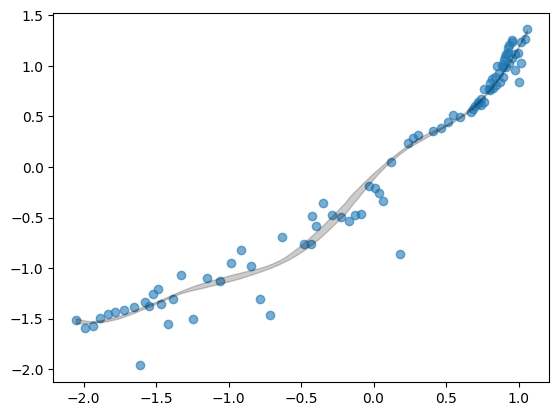

In [191]:
plt.scatter(x, y, alpha=0.6)
hpdi = numpyro.diagnostics.hpdi(pred, prob=0.9, axis=0)
plt.fill_between(true_t, hpdi[0], hpdi[1], alpha=0.2, color="black")

# EIV


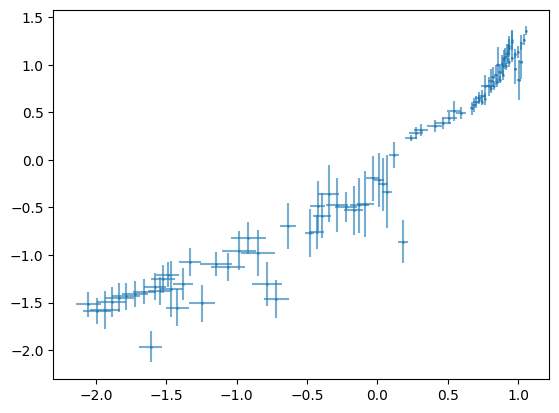

In [56]:
def standardize_with_uncertainties(x: pd.Series, x_error: pd.Series):
    """Standardize both values and their uncertainties"""
    x_std = x.std()
    x_mean = x.mean()

    # For the main values: (x - mean) / std
    x_standardized = ((x - x_mean) / x_std).to_numpy()

    # For uncertainties: only divide by std (don't subtract mean)
    x_error_standardized = (x_error / x_std).to_numpy()

    return x_standardized, x_error_standardized


x, x_err = standardize_with_uncertainties(df["Age"] / 1000, df["AgeError"] / 1000)
y, y_err = standardize_with_uncertainties(df["RSL"], df["RSLError"])

plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt="o", markersize=1, alpha=0.6);

sample: 100%|██████████| 2500/2500 [00:01<00:00, 2348.34it/s, 11 steps of size 8.32e-01. acc. prob=0.89]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.00      0.03     -0.00     -0.04      0.04   1665.26      1.00
      beta      0.97      0.03      0.97      0.92      1.01   2429.59      1.00
     sigma      0.25      0.02      0.25      0.22      0.28   2265.83      1.00

Number of divergences: 0


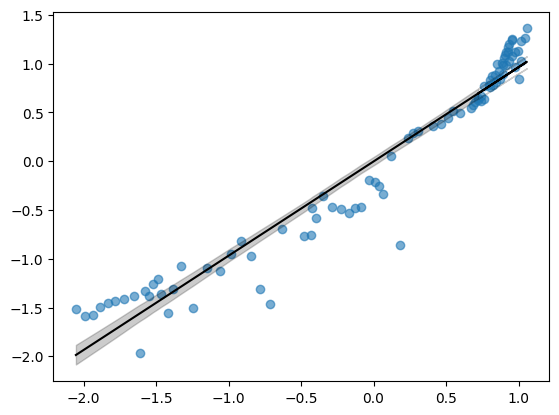

In [94]:
def linear_reg(x, y):
    alpha = numpyro.sample("alpha", dist.Normal(-1.0, 0.5))
    beta = numpyro.sample("beta", dist.Normal(0, 0.5))
    # error in y
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", alpha + beta * x)
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)


k = NUTS(linear_reg)
mcmc = MCMC(k, num_warmup=500, num_samples=2000)
mcmc.run(random.PRNGKey(0), x=x, y=y)
mcmc.print_summary()

posterior = mcmc.get_samples()
means = posterior["mu"]
plt.scatter(x, y, alpha=0.6)
plt.plot(x, np.mean(means, axis=0), color="black")
hpdi = numpyro.diagnostics.hpdi(means, prob=0.9, axis=0)
plt.fill_between(x, hpdi[0], hpdi[1], alpha=0.2, color="black")


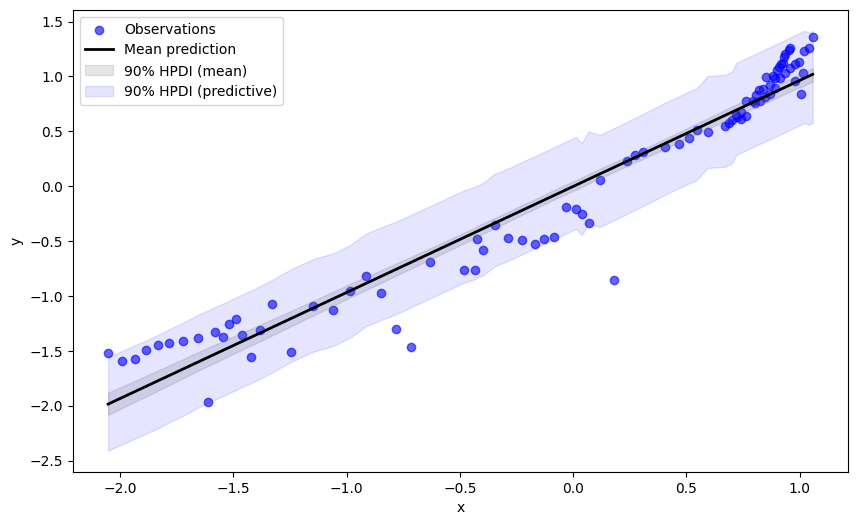

In [95]:
# Get posterior samples
posterior = mcmc.get_samples()

# Create ordered x values for smooth plotting
x_ord = np.sort(x)

# For each posterior sample, compute predictions
y_preds_mean = []  # for mean line
y_preds_full = []  # for full predictive distribution
for i in range(len(posterior["alpha"])):
    # Mean prediction
    y_pred_mean = posterior["alpha"][i] + posterior["beta"][i] * x_ord
    y_preds_mean.append(y_pred_mean)

    # Add noise using sigma for full predictive distribution
    y_pred_full = y_pred_mean + random.normal(random.PRNGKey(i)) * posterior["sigma"][i]
    y_preds_full.append(y_pred_full)

y_preds_mean = np.array(y_preds_mean)
y_preds_full = np.array(y_preds_full)

plt.figure(figsize=(10, 6))

# Plot data points
plt.scatter(x, y, alpha=0.6, color="blue", label="Observations")

# Plot mean prediction line
plt.plot(
    x_ord, np.mean(y_preds_mean, axis=0), "k-", linewidth=2, label="Mean prediction"
)

# Add uncertainty bands for mean
mean_hpdi = numpyro.diagnostics.hpdi(y_preds_mean, prob=0.9)
plt.fill_between(
    x_ord, mean_hpdi[0], mean_hpdi[1], color="gray", alpha=0.2, label="90% HPDI (mean)"
)

# Add predictive intervals
pred_hpdi = numpyro.diagnostics.hpdi(y_preds_full, prob=0.9)
plt.fill_between(
    x_ord,
    pred_hpdi[0],
    pred_hpdi[1],
    color="blue",
    alpha=0.1,
    label="90% HPDI (predictive)",
)

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [96]:
# def linear_reg_eiv(x, y, x_err, y_err):
#     alpha = numpyro.sample("alpha", dist.Normal(-1.0, 0.5))
#     beta = numpyro.sample("beta", dist.Normal(0, 0.5))

#     x_true = numpyro.sample("x_true", dist.Normal(0, 1).expand([len(x)]))
#     numpyro.sample("x_obs", dist.Normal(x_true, x_err), obs=x)

#     sigma = numpyro.sample("sigma", dist.Normal(0.01, 1))
#     mu = numpyro.sample("mu", dist.Normal(alpha + beta * x_true, sigma))
#     numpyro.sample("y", dist.Normal(mu, y_err), obs=y)


def linear_reg_eiv(x, y, x_err, y_err):
    D = jnp.c_[x, y]

    alpha = numpyro.sample("alpha", dist.Normal(-1.0, 0.5))
    beta = numpyro.sample("beta", dist.Normal(0, 0.5))
    x_true = numpyro.sample("x_true", dist.Normal(0, np.sqrt(1000)).expand([len(x)]))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))

    def get_cov(x_err_i, y_err_i):
        # add additional microscale variance to y
        cov = jnp.array(
            [
                [x_err_i**2, 0],
                [0, y_err_i**2 + sigma**2],
            ]
        )
        return cov

    cov = jax.vmap(get_cov)(x_err, y_err)

    mu_y = numpyro.deterministic("mu_y", alpha + beta * x_true)
    means = jnp.column_stack([x_true, mu_y])

    # multivariate normal allows correlations/cov between x and y via the kernel
    with numpyro.plate("observation", len(D)):
        numpyro.sample(
            "z",
            dist.MultivariateNormal(means, cov),
            obs=D,
        )


k = NUTS(linear_reg_eiv)
mcmc = MCMC(k, num_warmup=500, num_samples=2000)
mcmc.run(random.PRNGKey(0), x=x, y=y, x_err=x_err, y_err=y_err)
mcmc.print_summary()

posterior = mcmc.get_samples()

sample: 100%|██████████| 2500/2500 [00:02<00:00, 1098.10it/s, 15 steps of size 3.32e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.04      0.02      0.04      0.01      0.08   4872.41      1.00
      beta      0.97      0.02      0.97      0.94      1.01   3773.06      1.00
     sigma      0.14      0.02      0.14      0.10      0.17   3523.45      1.00
 x_true[0]      0.72      0.00      0.72      0.72      0.73   2010.49      1.00
 x_true[1]      0.74      0.01      0.74      0.73      0.75   3446.19      1.00
 x_true[2]      0.76      0.01      0.76      0.75      0.77   3225.86      1.00
 x_true[3]      0.80      0.01      0.80      0.79      0.81   3330.15      1.00
 x_true[4]      0.83      0.01      0.83      0.82      0.83   2561.49      1.00
 x_true[5]      0.85      0.01      0.85      0.84      0.86   2424.36      1.00
 x_true[6]      0.87      0.01      0.87      0.86      0.88   2256.61      1.00
 x_true[7]      0.89      0.01      0.89      0.88      0.90   3834.92      1.00
 x_true[8]      0.91      0

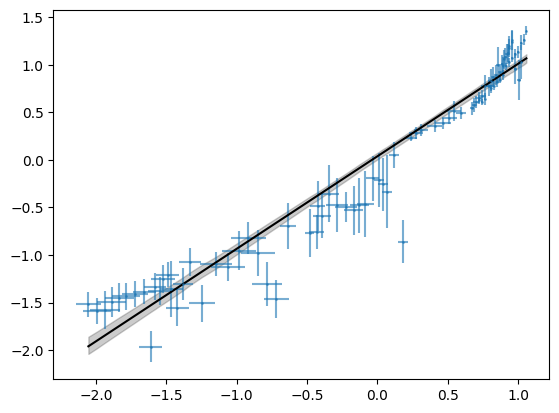

In [97]:
# means = posterior["mu_y"] # this uses x_true which can vary randomly
means = posterior["alpha"][:, None] + posterior["beta"][:, None] * x


s_idx = jnp.argsort(x)
plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt="o", markersize=1, alpha=0.6)
plt.plot(x[s_idx], np.mean(means, axis=0)[s_idx], color="black")
hpdi = numpyro.diagnostics.hpdi(means, prob=0.9, axis=0)
plt.fill_between(x[s_idx], hpdi[0][s_idx], hpdi[1][s_idx], alpha=0.2, color="black")

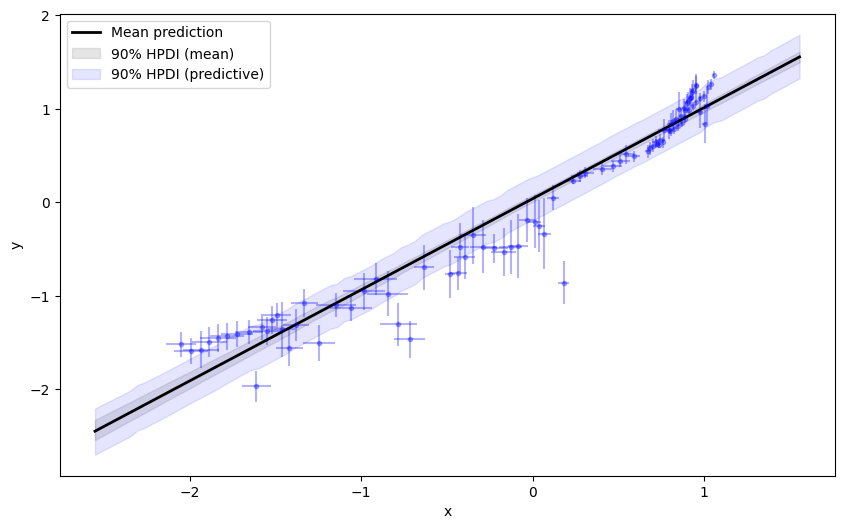

In [98]:
# Get the posterior samples
posterior = mcmc.get_samples()

# Create a grid of x values for smooth plotting
x_grid = np.linspace(x.min() - 0.5, x.max() + 0.5, 100)

# For each posterior sample, compute the predicted y AND add random noise from sigma
y_preds_mean = []  # for the mean line
y_preds_full = []  # for the full predictive distribution
for i in range(len(posterior["alpha"])):
    # Mean prediction
    y_pred_mean = posterior["alpha"][i] + posterior["beta"][i] * x_grid
    y_preds_mean.append(y_pred_mean)

    # Add noise using sigma for full predictive distribution
    y_pred_full = y_pred_mean + random.normal(random.PRNGKey(i)) * posterior["sigma"][i]
    y_preds_full.append(y_pred_full)

y_preds_mean = np.array(y_preds_mean)
y_preds_full = np.array(y_preds_full)

plt.figure(figsize=(10, 6))

# Plot data points with error bars
plt.errorbar(
    x, y, xerr=x_err, yerr=y_err, fmt="o", color="blue", alpha=0.3, markersize=3
)

# Plot mean prediction line
plt.plot(
    x_grid, np.mean(y_preds_mean, axis=0), "k-", linewidth=2, label="Mean prediction"
)

# Add uncertainty bands for mean
mean_hpdi = numpyro.diagnostics.hpdi(y_preds_mean, prob=0.9)
plt.fill_between(
    x_grid, mean_hpdi[0], mean_hpdi[1], color="gray", alpha=0.2, label="90% HPDI (mean)"
)

# Add predictive intervals
pred_hpdi = numpyro.diagnostics.hpdi(y_preds_full, prob=0.9)
plt.fill_between(
    x_grid,
    pred_hpdi[0],
    pred_hpdi[1],
    color="blue",
    alpha=0.1,
    label="90% HPDI (predictive)",
)

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

main difference when introducing errors in variables here - the hpdi is narrower, because there are more possibilities for x now, within it's uncertainty ranges!


let's now do the same with a GP!


sample: 100%|██████████| 2500/2500 [00:08<00:00, 306.96it/s, 15 steps of size 3.79e-01. acc. prob=0.94]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    jitter      0.00      0.00      0.00      0.00      0.00    324.52      1.00
      mean      0.26      1.51      0.10     -2.06      2.40    696.24      1.00
     sigma      2.21      1.28      1.84      0.72      3.87    542.52      1.01
       tau      0.79      0.38      0.76      0.50      1.02    265.20      1.01

Number of divergences: 0
(2000, 100)


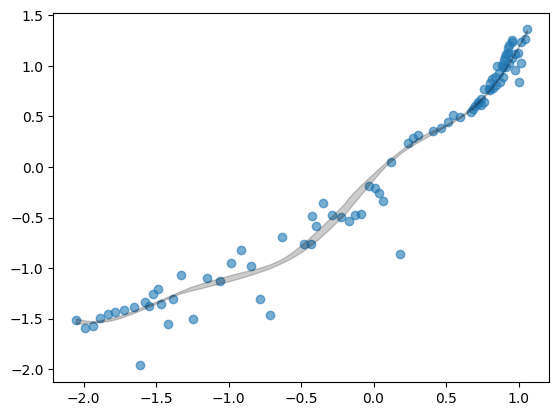

In [196]:
x_test = np.linspace(x.min(), x.max(), 100)


def gp_eiv(x, x_err, y, y_err):
    mean = numpyro.sample("mean", dist.Normal(0.0, 5))
    jitter = numpyro.sample("jitter", dist.HalfNormal(5))
    sigma = numpyro.sample("sigma", dist.HalfNormal(5))
    tau = numpyro.sample("tau", dist.HalfNormal(5))
    kernel = sigma**2 * kernels.ExpSquared(tau)

    gp = GaussianProcess(kernel, x, diag=y_err**2 + jitter, mean=mean)
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)
    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, x_test).gp.loc)


k = NUTS(gp_eiv)
mcmc = MCMC(k, num_warmup=500, num_samples=2000)
mcmc.run(random.PRNGKey(0), x=x, y=y, y_err=y_err, x_err=x_err)
mcmc.print_summary()
# viz
posterior = mcmc.get_samples()
pred = posterior["pred"].block_until_ready()
print(pred.shape)
plt.scatter(x, y, alpha=0.6)
hpdi = numpyro.diagnostics.hpdi(pred, prob=0.9, axis=0)
plt.fill_between(x_test, hpdi[0], hpdi[1], alpha=0.2, color="black")

# EIV IGP


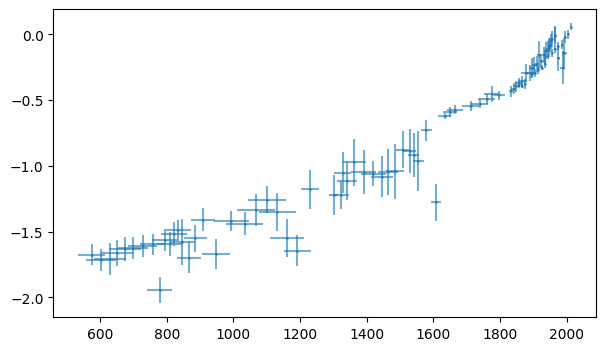

In [3]:
plt.figure(figsize=(7, 4))
plt.errorbar(
    df["Age"],
    df["RSL"],
    xerr=df["AgeError"],
    yerr=df["RSLError"],
    fmt="o",
    markersize=1,
    alpha=0.6,
);

In [ ]:
# We're not accounting for GIA to begin with
year_of_correction = 2010
convert_bp_to_ce = False
interval = 30  # years
kappa = 1.99


# preprocessing

df["x"] = (1950 - df["Age"]) if convert_bp_to_ce else df["Age"]
df["y"] = df["RSL"]
df["var_x"] = (df["AgeError"] / 1000) ** 2  # x in thousands of years
df["var_y"] = df["RSLError"] ** 2
# variance and precision matrices
V = np.empty((2, 2, len(df)))
P = np.empty((2, 2, len(df)))
for i in range(len(df)):
    V[:, :, i] = np.array(
        [
            [df["var_x"].iloc[i], 0.0],  # ill add it modelling x_trye
            [0.0, df["var_y"].iloc[i]],  # all add to the diag later
        ]
    )
    P[:, :, i] = np.linalg.inv(V[:, :, i])

# include error bounds by default
x_max = (df["x"] + df["AgeError"]).max() / 1000
x_min = (df["x"] - df["AgeError"]).min() / 1000
x_grid = np.concatenate(
    [
        [x_min],  # scalar
        np.arange(min(df["x"] / 1000), max(df["x"] / 1000), interval / 1000),
        [x_max],  # scalar
    ]
)
x = (df["x"] / 1000) - min(df["x"] / 1000)
x_star = x_grid - min(df["x"] / 1000)
Ngrid = len(x_star)
# add axis to x_star
Dist = cdist(x_star[:, None], x_star[:, None], metric="euclidean")
D = np.c_[x, df["y"]]

## quadrature init
L = 30
index = np.arange(1, L + 1)
# cosfunc = np.cos(np.pi * (index + 0.5) / L)
cosfunc = np.cos((np.pi * (2 * index - 1)) / (2 * L))
# plt.scatter(range(len(cosfunc)), cosfunc)
quad1 = np.zeros((len(df), Ngrid, L))
quad2 = np.ones((len(df), Ngrid, L))

for j in range(Ngrid):
    for k in range(len(df)):
        quad1[k, j, :] = np.abs((x[k] * cosfunc / 2) + (x[k] / 2) - x_star[j]) ** kappa
        quad2[k, j, :] = (x[k] / 2) * (np.pi / L) * (np.sqrt(1 - cosfunc**2))


V = V.transpose(2, 0, 1)
jags_data = {
    "V": V,
    "P_t": P[:, :].transpose(2, 0, 1),
    "n": len(df),  # c
    "m": Ngrid,  # c
    "P": P,  # c
    "D": D,  # c
    "L": L,  # c
    "ppi": np.pi,  # c
    "cosfunc": cosfunc,  # c
    "Dist": Dist,  # c
    "xstar": x_star,  # c
    "quad1": quad1,  # c
    "quad2": quad2,  # c
    "kappa": kappa,  # c
    "cor.p": 0.2,  # c
}


In [5]:
V = jnp.array(V)
D = jnp.array(D)
Dist = jnp.array(Dist)
quad1 = jnp.array(quad1)
quad2 = jnp.array(quad2)

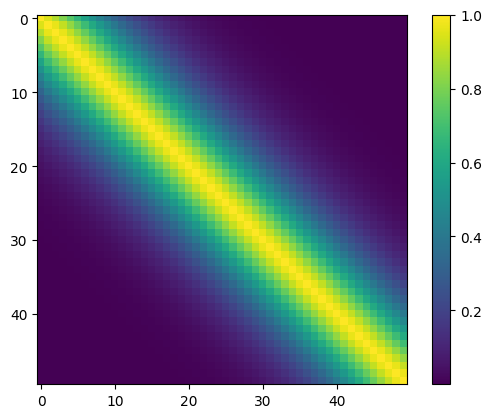

In [6]:
m = Ngrid
K = jnp.zeros((m, m))
# Add small constant to diagonal for numerical stability
K = K.at[jnp.diag_indices(m)].set(1 + 1e-5)
# Off-diagonal elements using powered exponential covariance
i, j = jnp.triu_indices(m, k=1)
triu_values = 0.1 ** ((Dist[i, j] / 0.5) ** 1.5)
K = K.at[i, j].set(triu_values)
K = K.at[j, i].set(triu_values)
plt.imshow(K)
plt.colorbar()

dict_keys(['beta0', 'mu_y', 'p', 'sigma', 'tau_g', 'w_m', 'x_true', 'z'])


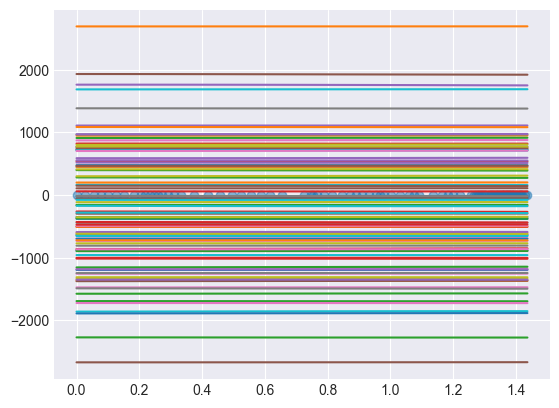

In [35]:
# def eiv_igp(D=D, V=V, K=K, m=Ngrid, quad1=quad1, quad2=quad2):
#     # print("hi")
#     N = len(V)
#     # x_true = numpyro.sample("x_true", dist.Normal(0, np.sqrt(1e3)).expand([len(D)]))
#     x_true = numpyro.sample("x_true", dist.Normal(0, np.sqrt(1e3)).expand([N]))
#     # beta0 = numpyro.sample("beta0", dist.Normal(0, 1000.0))
#     beta0 = numpyro.sample("beta0", dist.Normal(0, 1.0))
#     sigma = numpyro.sample("sigma", dist.Uniform(0.01, 1))
#     p = numpyro.sample("p", dist.Uniform(0, 1))
#     tau_g = numpyro.sample("tau_g", dist.Gamma(10.0, 100.0))
#     # gp_len = numpyro.sample("gp_len", dist.LogNormal(0, 10))

#     # precision is just inverse of covariance
#     # K_inv = jnp.linalg.inv((1 / tau_g) * K)
#     K_scaled = K / tau_g
#     w_m = numpyro.sample(
#         "w_m",
#         dist.MultivariateNormal(jnp.zeros(m), K_scaled),
#     )

#     K_gw = jnp.sum(p**quad1 * quad2, axis=2)

#     # K_w_inv = jnp.linalg.inv(K)  # inv of unscaled!
#     # Use Cholesky decomposition for potentially better stability
#     L_unscaled = jax.scipy.linalg.cholesky(K, lower=True)
#     K_w_inv = jax.scipy.linalg.cho_solve((L_unscaled, True), jnp.eye(Ngrid))

#     w_tilde_m = jnp.matmul(K_gw, jnp.matmul(K_w_inv, w_m))

#     mu_y = numpyro.deterministic("mu_y", beta0 + w_tilde_m)

#     # if jnp.isnan(K).any():
#     #     print("NaN values detected in mu_y")

#     mu = jnp.c_[
#         x_true,
#         mu_y,
#     ]
#     V_new = V.at[:, 1, 1].set(V[:, 1, 1] + sigma**2)

#     with numpyro.plate("observations", len(D)):
#         numpyro.sample(
#             "z",
#             dist.MultivariateNormal(
#                 mu,
#                 V_new,
#             ),
#             obs=D,
#         )


# def eiv_igp(D, V, Ngrid, Dist_jnp, kappa, quad1, quad2):  # Removed K from args
def eiv_igp(D=D, V=V, m=Ngrid, quad1=quad1, quad2=quad2):
    N = len(V)
    m = Ngrid  # Grid size

    # Sample parameters
    x_true = numpyro.sample("x_true", dist.Normal(0, jnp.sqrt(1000.0)).expand([N]))
    # Use the weak prior for beta0 matching JAGS
    beta0 = numpyro.sample("beta0", dist.Normal(0, 1000.0))
    sigma = numpyro.sample("sigma", dist.Uniform(0.01, 1.0))  # microscale for y
    p = numpyro.sample("p", dist.Uniform(0.0, 1.0))
    tau_g = numpyro.sample("tau_g", dist.Gamma(10.0, 100.0))  # GP rate precision

    # --- Construct K_unscaled using sampled p ---
    K_unscaled = jnp.zeros((m, m))
    # Add jitter for numerical stability BEFORE Cholesky
    K_unscaled = K_unscaled.at[jnp.diag_indices(m)].set(
        1.0 + 1e-6
    )  # Increased jitter slightly
    i_idx, j_idx = jnp.triu_indices(m, k=1)
    # Ensure p is not exactly 0 or 1 to avoid potential NaN/Inf in power/log
    p_safe = jnp.clip(p, 1e-9, 1.0 - 1e-9)
    triu_values = p_safe ** ((Dist[i_idx, j_idx]) ** kappa)
    K_unscaled = K_unscaled.at[i_idx, j_idx].set(triu_values)
    K_unscaled = K_unscaled.at[j_idx, i_idx].set(triu_values)  # Mirror symmetric part
    # Optional: Track K_unscaled if needed for debugging
    # K_unscaled = numpyro.deterministic("K_unscaled", K_unscaled)
    # --- End K_unscaled construction ---

    # Calculate K_scaled for sampling w_m
    K_scaled = K_unscaled / tau_g
    # Optional: Add small jitter also to K_scaled just before sampling if needed
    # K_scaled = K_scaled + jnp.eye(m) * 1e-10
    w_m = numpyro.sample(
        "w_m",
        dist.MultivariateNormal(jnp.zeros(m), covariance_matrix=K_scaled),
    )

    # Calculate K_gw (integration matrix)
    K_gw = jnp.sum(p_safe**quad1 * quad2, axis=2)  # Use p_safe here too

    # --- Solve K_unscaled @ z = w_m for z using Cholesky ---
    try:
        # Compute Cholesky factor L: K_unscaled = L @ L.T
        L_unscaled = jax.scipy.linalg.cholesky(K_unscaled, lower=True)

        # Solve L @ x = w_m
        x_sol = jax.scipy.linalg.solve_triangular(L_unscaled, w_m, lower=True)
        # Solve L.T @ z = x_sol
        z = jax.scipy.linalg.solve_triangular(L_unscaled, x_sol, lower=True, trans="T")
        # Now z is equivalent to inv(K_unscaled) @ w_m
        K_unscaled_inv_w_m = z

    except jnp.linalg.LinAlgError:
        # Fallback if Cholesky fails (matrix not positive definite)
        # This indicates potential issues with K_unscaled becoming ill-conditioned
        print("Warning: Cholesky failed, falling back to pseudo-inverse.")
        K_unscaled_inv = jnp.linalg.pinv(K_unscaled)
        K_unscaled_inv_w_m = jnp.matmul(K_unscaled_inv, w_m)
    # --- End Solve ---

    # Calculate integrated process mean component
    w_tilde_m = jnp.matmul(K_gw, K_unscaled_inv_w_m)
    mu_y = numpyro.deterministic("mu_y", beta0 + w_tilde_m)

    # Construct the full mean vector [x_true, mu_y]
    mu = jnp.c_[
        x_true,
        mu_y,
    ]
    # Optional: Track mu if needed
    # mu = numpyro.deterministic("mu", mu)

    # Construct final observation covariance (add microscale variance sigma)
    # Assumes input V has only measurement error variance
    V_new = V.at[:, 1, 1].set(V[:, 1, 1] + sigma**2)

    # Likelihood
    with numpyro.plate("observations", N):  # Ensure N matches expand shape
        numpyro.sample(
            "z",
            dist.MultivariateNormal(
                mu,
                covariance_matrix=V_new,
            ),
            obs=D,
        )


pp = Predictive(eiv_igp, num_samples=100)
prior_predictive = pp(random.PRNGKey(0))
print(prior_predictive.keys())
plt.scatter(D[:, 0], D[:, 1], alpha=0.5)
mu = prior_predictive["mu_y"]
s_idx = jnp.argsort(D[:, 0])
for i in range(len(mu)):
    plt.plot(D[:, 0][s_idx], mu[i][s_idx])
    # break

In [36]:
mcmc = MCMC(
    NUTS(
        eiv_igp,
        dense_mass=True,
        init_strategy=numpyro.infer.init_to_median,
    ),
    # numpyro.infer.SA(
    #     eiv_igp,
    #     init_strategy=numpyro.infer.init_to_median,
    # ),
    num_warmup=100,
    num_samples=200,
)
mcmc.run(random.PRNGKey(0))
mcmc.print_summary()

posterior = mcmc.get_samples()

sample: 100%|██████████| 300/300 [13:13<00:00,  2.65s/it, 1023 steps of size 6.03e-04. acc. prob=0.97]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     12.23      8.74      8.18      7.61     31.07      5.60      1.28
         p      0.11      0.01      0.12      0.10      0.12      5.55      1.08
     sigma      1.00      0.00      1.00      1.00      1.00      3.63      1.77
     tau_g      0.01      0.00      0.01      0.01      0.01      8.73      1.35
    w_m[0]     -1.94      0.04     -1.92     -2.02     -1.90      7.47      1.12
    w_m[1]     -5.27      0.08     -5.30     -5.35     -5.10      5.91      1.42
    w_m[2]     -7.77      0.26     -7.90     -7.95     -7.23      4.40      1.46
    w_m[3]     -9.31      0.34     -9.47     -9.49     -8.56      5.07      1.29
    w_m[4]     -9.79      0.25     -9.91     -9.98     -9.28      4.15      1.55
    w_m[5]    -10.06      0.18    -10.13    -10.21     -9.67      7.19      1.15
    w_m[6]    -10.08      0.20    -10.17    -10.23     -9.66      4.79      1.46
    w_m[7]     -9.84      0

<Axes: ylabel='Density'>

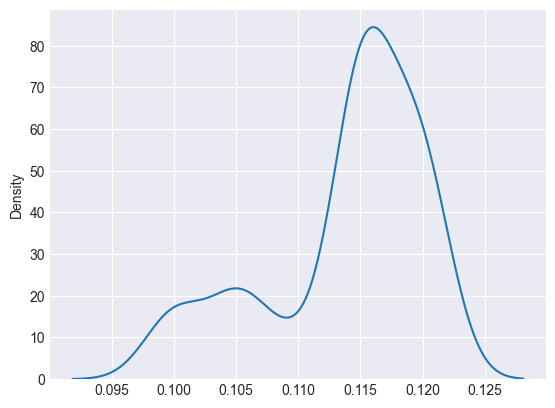

In [37]:
import seaborn as sns

sns.kdeplot(posterior["p"])

Shape of posterior SL on grid: (200, 50)
Shape of posterior Rates on grid: (200, 50)


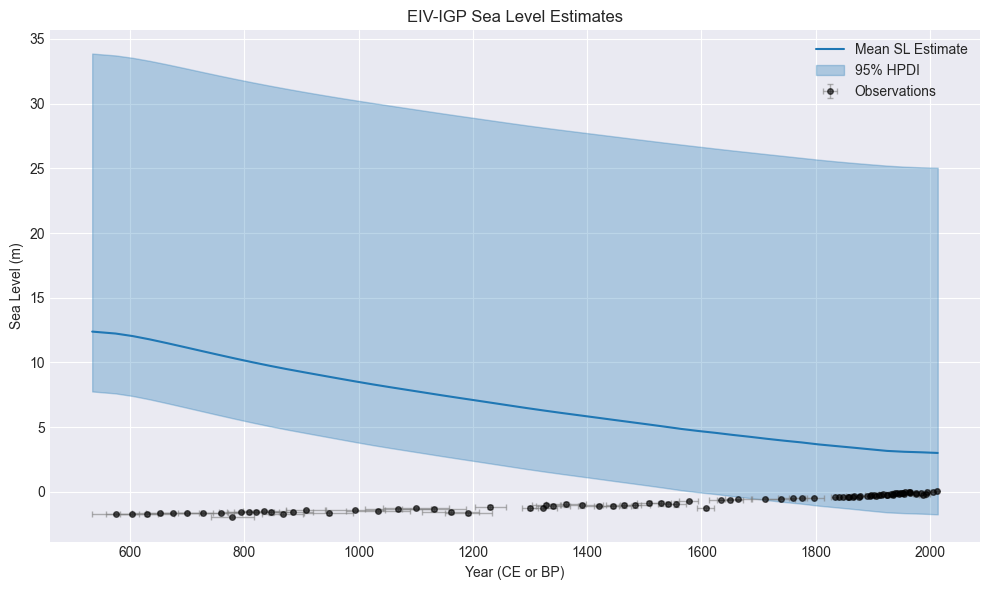

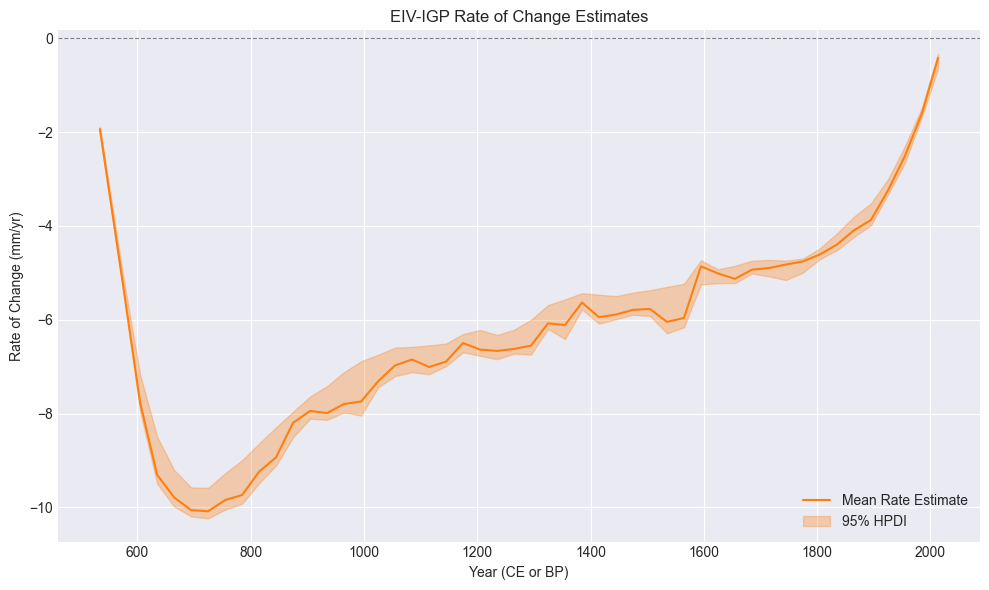

In [38]:
from scipy.spatial.distance import cdist

# --- Assume you have run the MCMC and have: ---
# posterior: dictionary of posterior samples
# D, V: Original data and covariance matrices used as input
# x_star: The grid points (relative/shifted) used in the model (shape m)
# Dist: Distance matrix for x_star (shape m, m)
# kappa: The kappa value (e.g., 1.99)
# cosfunc, L: Quadrature parameters
# min_x_original: The value subtracted to shift x for the model
# Ngrid (m): Number of grid points
# ----------------------------------------------

# Extract necessary posterior samples
post_p = posterior["p"]
post_tau_g = posterior["tau_g"]
post_beta0 = posterior["beta0"]
post_w_m = posterior["w_m"]
num_samples = post_w_m.shape[0]

# --- Need to recalculate K_gw for grid -> grid mapping ---
# This requires quadrature arrays based on x_star vs x_star
# Pre-calculate these (adjust names to avoid confusion)
quad1_grid = np.zeros((Ngrid, Ngrid, L))
quad2_grid = np.ones((Ngrid, Ngrid, L))
for j in range(Ngrid):
    for k in range(Ngrid):  # Both loops go up to Ngrid
        quad1_grid[k, j, :] = (
            np.abs((x_star[k] * cosfunc / 2) + (x_star[k] / 2) - x_star[j]) ** kappa
        )
        quad2_grid[k, j, :] = (x_star[k] / 2) * (np.pi / L) * (np.sqrt(1 - cosfunc**2))

# Convert to JAX arrays
quad1_grid_jnp = jnp.array(quad1_grid)
quad2_grid_jnp = jnp.array(quad2_grid)
Dist_jnp = jnp.array(Dist)  # Make sure Dist is available as jnp array


# Define a function to calculate grid SL for one posterior sample
def calculate_grid_sl(p_i, tau_g_i, beta0_i, w_m_i):
    # Reconstruct unscaled kernel K
    K_unscaled = jnp.zeros((Ngrid, Ngrid))
    K_unscaled = K_unscaled.at[jnp.diag_indices(Ngrid)].set(1 + 1e-5)
    i_idx, j_idx = jnp.triu_indices(Ngrid, k=1)
    triu_values = p_i ** ((Dist_jnp[i_idx, j_idx]) ** kappa)
    K_unscaled = K_unscaled.at[i_idx, j_idx].set(triu_values)
    K_unscaled = K_unscaled.at[j_idx, i_idx].set(triu_values)

    # Calculate inverse of unscaled K (consider stability)
    try:
        # Use Cholesky decomposition for potentially better stability
        L_unscaled = jax.scipy.linalg.cholesky(K_unscaled, lower=True)
        K_unscaled_inv = jax.scipy.linalg.cho_solve((L_unscaled, True), jnp.eye(Ngrid))
    except jnp.linalg.LinAlgError:
        print("Warning: K_unscaled singular for a sample, using pseudo-inverse.")
        K_unscaled_inv = jnp.linalg.pinv(K_unscaled)

    # Calculate K_gw_grid mapping grid rates to grid SL
    K_gw_grid = jnp.sum(p_i**quad1_grid_jnp * quad2_grid_jnp, axis=2)

    # Calculate integrated GP part on the grid
    mu_y_grid_gp = jnp.matmul(K_gw_grid, jnp.matmul(K_unscaled_inv, w_m_i))

    # Add intercept
    mu_y_grid = beta0_i + mu_y_grid_gp
    return mu_y_grid


# Vectorize the calculation over the posterior samples
# Note: Jitting might require static shapes for grid/quadrature arrays
vmap_calculate_grid_sl = jax.vmap(calculate_grid_sl)
posterior_mu_y_grid = vmap_calculate_grid_sl(post_p, post_tau_g, post_beta0, post_w_m)
# posterior_mu_y_grid will have shape (num_samples, m)

# Posterior rates on the grid are just post_w_m
posterior_rates_grid = post_w_m

print(f"Shape of posterior SL on grid: {posterior_mu_y_grid.shape}")
print(f"Shape of posterior Rates on grid: {posterior_rates_grid.shape}")

# --- Now calculate summary statistics ---
mean_sl_grid = jnp.mean(posterior_mu_y_grid, axis=0)
std_sl_grid = jnp.std(posterior_mu_y_grid, axis=0)
hpdi_sl_grid_95 = numpyro.diagnostics.hpdi(posterior_mu_y_grid, prob=0.95, axis=0)
# Or use percentiles:
# q_sl_grid = jnp.percentile(posterior_mu_y_grid, jnp.array([2.5, 97.5]), axis=0)

mean_rates_grid = jnp.mean(posterior_rates_grid, axis=0)
std_rates_grid = jnp.std(posterior_rates_grid, axis=0)
hpdi_rates_grid_95 = numpyro.diagnostics.hpdi(posterior_rates_grid, prob=0.95, axis=0)
# Or use percentiles:
# q_rates_grid = jnp.percentile(posterior_rates_grid, jnp.array([2.5, 97.5]), axis=0)

# Convert grid back to original time scale for plotting
# Assumes x_star = (original_x / 1000) - min_x_original
# So, original_x_star = (x_star + min_x_original) * 1000
# Replace min_x_original with the actual value you used
# If you standardized, you'll need to un-standardize here.
# If no shift/scaling was done beyond /1000, then:
# x_plot = x_star * 1000 # Adjust based on your preprocessing

# Example: Assuming x_star = x_original_kyear - min(x_original_kyear)
# Need the minimum kyear value that was subtracted during preprocessing
try:
    # Assuming 'x' was defined in the global scope during preprocessing
    min_x_kyear_original = min(
        df["x"] / 1000
    )  # Get the minimum from original data prep
    x_plot = (x_star + min_x_kyear_original) * 1000
    # Also get original data's x and y for plotting
    x_orig_plot = (D[:, 0] + min_x_kyear_original) * 1000
    y_orig_plot = D[:, 1]
    # Get original errors (assuming V was diagonal before adding sigma)
    x_err_orig_plot = jnp.sqrt(V[:, 0, 0]) * 1000  # Convert kyear back to year
    y_err_orig_plot = jnp.sqrt(V[:, 1, 1])  # RSL error
except NameError:
    print(
        "Warning: Could not find original scaling factor 'min_x_kyear_original'. Plotting against relative x_star."
    )
    x_plot = x_star  # Fallback
    x_orig_plot = D[:, 0]
    y_orig_plot = D[:, 1]
    x_err_orig_plot = jnp.sqrt(V[:, 0, 0])
    y_err_orig_plot = jnp.sqrt(V[:, 1, 1])


# Step 2: Plotting

plt.style.use("seaborn-v0_8-darkgrid")  # Or your preferred style

# Plot 1: Sea Level Estimates
fig1, ax1 = plt.subplots(figsize=(10, 6))
# Plot mean prediction
ax1.plot(x_plot, mean_sl_grid, label="Mean SL Estimate", color="C0")
# Plot 95% HPDI band
ax1.fill_between(
    x_plot,
    hpdi_sl_grid_95[0],
    hpdi_sl_grid_95[1],
    alpha=0.3,
    color="C0",
    label="95% HPDI",
)
# Plot original data with error bars (simpler than polygons if GIA is off)
ax1.errorbar(
    x_orig_plot,
    y_orig_plot,
    yerr=y_err_orig_plot,
    xerr=x_err_orig_plot,
    fmt="o",
    markersize=4,
    alpha=0.6,
    color="black",
    ecolor="gray",
    elinewidth=1,
    capsize=2,
    label="Observations",
)
ax1.set_xlabel("Year (CE or BP)")  # Adjust label based on data
ax1.set_ylabel("Sea Level (m)")
ax1.set_title("EIV-IGP Sea Level Estimates")
ax1.legend()
plt.tight_layout()
plt.show()

# Plot 2: Rate Estimates
fig2, ax2 = plt.subplots(figsize=(10, 6))
# Plot mean rate prediction
ax2.plot(x_plot, mean_rates_grid, label="Mean Rate Estimate", color="C1")
# Plot 95% HPDI band for rates
ax2.fill_between(
    x_plot,
    hpdi_rates_grid_95[0],
    hpdi_rates_grid_95[1],
    alpha=0.3,
    color="C1",
    label="95% HPDI",
)
ax2.axhline(0, linestyle="--", color="gray", linewidth=0.8)  # Add zero line
ax2.set_xlabel("Year (CE or BP)")  # Adjust label
ax2.set_ylabel("Rate of Change (mm/yr)")  # Assuming input RSL was meters, Age kyears
ax2.set_title("EIV-IGP Rate of Change Estimates")
ax2.legend()
plt.tight_layout()
plt.show()

# gemini


In [46]:
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax.scipy.linalg import solve_triangular

jax.config.update("jax_enable_x64", True)

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.infer.initialization import init_to_median

# Set random seed for reproducibility
rng_key = jax.random.PRNGKey(0)

# --- Data Preprocessing (adapted from your code) ---
df = pd.read_csv("./NYC.csv")
# We're not accounting for GIA to begin with
year_of_correction = 2010
convert_bp_to_ce = False
interval = 30  # years
kappa = 1.99  # Fixed smoothness parameter for Matern-like covariance

# preprocessing
df["x_yr"] = (1950 - df["Age"]) if convert_bp_to_ce else df["Age"]  # Age in years CE/BP
df["x_kilo_yr"] = df["x_yr"] / 1000.0  # Age in kilo years
df["y"] = df["RSL"]  # RSL in meters
df["x_err_kilo_yr"] = df["AgeError"] / 1000.0  # Age uncertainty in kilo years
df["y_err"] = df["RSLError"]  # RSL uncertainty in meters

# Observation variance/covariance/precision matrices
# Assuming independence between age and RSL measurement errors initially
# V: Covariance matrix for observation [i], P: Precision matrix
V = np.zeros((len(df), 2, 2))
P = np.zeros((len(df), 2, 2))
for i in range(len(df)):
    V[i, 0, 0] = df["x_err_kilo_yr"].iloc[i] ** 2
    V[i, 1, 1] = df["y_err"].iloc[i] ** 2
    # V[i, 0, 1] = V[i, 1, 0] = 0.0 # No GIA correction initially
    try:
        P[i, :, :] = np.linalg.inv(V[i, :, :])
    except np.linalg.LinAlgError:
        # Handle potential non-invertibility, maybe add jitter
        print(f"Warning: Could not invert V for index {i}. Adding jitter.")
        V[i, :, :] += np.eye(2) * 1e-9
        P[i, :, :] = np.linalg.inv(V[i, :, :])


# Grid setup for the GP rates (w_m)
# 'x_grid_kilo_yr' corresponds to 'xgrid' in R code
# 'x_star_kilo_yr' corresponds to 'xstar' in R code (shifted grid)
x_max_kilo_yr = (df["x_kilo_yr"] + df["x_err_kilo_yr"]).max()
x_min_kilo_yr = (df["x_kilo_yr"] - df["x_err_kilo_yr"]).min()
x_grid_kilo_yr = np.concatenate(
    [
        np.array([x_min_kilo_yr]),
        np.arange(
            df["x_kilo_yr"].min(),
            df["x_kilo_yr"].max(),
            interval / 1000,  # interval in kilo years
        ),
        np.array([x_max_kilo_yr]),
    ]
)
# Ensure grid points are unique and sorted
x_grid_kilo_yr = np.unique(x_grid_kilo_yr)

# Shift grid and observed x values so the GP integration starts near 0
min_x_kilo_yr = df["x_kilo_yr"].min()
x_shifted_kilo_yr = (
    df["x_kilo_yr"].values - min_x_kilo_yr
)  # Corresponds to 'x' in R/JAGS (for quadrature)
x_star_shifted_kilo_yr = (
    x_grid_kilo_yr - min_x_kilo_yr
)  # Corresponds to 'xstar' in R/JAGS

N = len(df)
Ngrid = len(x_star_shifted_kilo_yr)

# Distance matrix for GP rates
# Needs shape (Ngrid, 1) for cdist
Dist = cdist(
    x_star_shifted_kilo_yr[:, None], x_star_shifted_kilo_yr[:, None], metric="euclidean"
)

# Observed data matrix D (N, 2), using *shifted* ages for consistency if needed by model
# The JAGS model uses the original D[i,1] (shifted x) and D[i,2] (y) as observations
# that are normally distributed around latent mu[i,1] (true shifted x) and mu[i,2] (true y).
D_obs = jnp.column_stack((jnp.array(x_shifted_kilo_yr), jnp.array(df["y"])))
# Keep original observed values for potential priors/initialization
x_obs_kilo_yr = jnp.array(df["x_kilo_yr"].values)
y_obs = jnp.array(df["y"].values)

# Quadrature setup constants
L = 30
index = jnp.arange(1, L + 1)
cosfunc = jnp.cos(((2 * index - 1) * jnp.pi) / (2 * L))


# --- NumPyro Model Definition ---


def calculate_Kgw_row(mu_x_k, x_input_k, p, x_star_shifted, cosfunc, L, kappa):
    """
    Calculates one row (for one observation k) of the K_gw matrix.
    K_gw represents the covariance between the integrated process at true age mu_x_k
    and the rate process at grid points x_star_shifted.

    Args:
        mu_x_k: Scalar latent true *shifted* age for observation k.
        x_input_k: Scalar observed *shifted* age (needed for quad2 calculation as per R code).
                   NOTE: R code uses x[k] (shifted obs age) in quad2, but mu[j,1] (latent true age)
                   in quad1. This seems inconsistent. Assuming R code intended mu_x_k for both.
                   Let's use mu_x_k based on the paper's intention (integral of rate).
        p: Scalar correlation parameter.
        x_star_shifted: 1D array of shifted GP grid points (size Ngrid).
        cosfunc: 1D array for quadrature (size L).
        L: Integer number of quadrature points.
        kappa: Float smoothness parameter.

    Returns:
        1D array representing the k-th row of K_gw (size Ngrid).
    """
    # Reshape for broadcasting: x_star (Ngrid, 1), cosfunc (L,)
    x_star_col = x_star_shifted[:, None]
    cosfunc_row = cosfunc[None, :]

    # Quadrature term 1: Depends on latent true age mu_x_k
    quad1_k = (
        jnp.abs((mu_x_k * cosfunc_row / 2) + (mu_x_k / 2) - x_star_col) ** kappa
    )  # Shape (Ngrid, L)

    # Quadrature term 2: Depends on latent true age mu_x_k (based on interpretation)
    # R code: quad2[k,j,]=((x[k]/2)*(pi/L))*(sqrt(1-cosfunc^2)) - uses observed x[k]
    # Paper implies integral depends on true age. Let's use mu_x_k.
    quad2_k = ((mu_x_k / 2) * (jnp.pi / L)) * (
        jnp.sqrt(1 - cosfunc_row**2)
    )  # Shape (1, L)

    # Calculate row of K_gw by summing over quadrature points (axis=-1)
    # K_gw[k, i] = sum_{l=1}^L p^{quad1_k(i, l)} * quad2_k(l)
    K_gw_k_row = jnp.sum((p**quad1_k) * quad2_k, axis=-1)  # Shape (Ngrid,)
    return K_gw_k_row


def eiv_igp_model(
    N,
    Ngrid,
    L,
    kappa,
    Dist,
    x_star_shifted,
    cosfunc,
    P_obs,  # Data constants
    D_obs=None,  # Observed data (N, 2) [shifted_age_obs, rsl_obs]
):
    """
    Errors-in-Variables Integrated Gaussian Process Model in NumPyro.

    Args:
        N: Number of observations.
        Ngrid: Number of grid points for the GP rate process.
        L: Number of quadrature points.
        kappa: Smoothness parameter for the covariance function.
        Dist: (Ngrid, Ngrid) distance matrix for grid points.
        x_star_shifted: (Ngrid,) array of shifted GP grid points.
        cosfunc: (L,) array for quadrature calculations.
        P_obs: (N, 2, 2) array of precision matrices for observations.
        D_obs: (N, 2) array of observed data [shifted_age_obs, rsl_obs]. Optional, used for inference.
    """
    # --- Priors ---
    # Intercept for the integrated process mean
    beta0 = numpyro.sample("beta0", dist.Normal(0.0, 1000.0))  # Vague prior

    # Correlation parameter for the GP rate covariance
    p = numpyro.sample("p", dist.Uniform(0.0, 1.0))

    # Micro-scale variance (additional RSL variance beyond measurement error)
    sigma_y = numpyro.sample("sigma_y", dist.Uniform(0.01, 1.0))
    tau_y = sigma_y**-2

    # GP rate process variance/precision
    # Prior on precision tau_g ~ Gamma(shape=10, rate=100) -> E=0.1, Var=0.001
    # NumPyro Gamma uses concentration (shape) and rate
    tau_g = numpyro.sample("tau_g", dist.Gamma(10.0, 100.0))
    sigma_g = tau_g**-0.5
    numpyro.deterministic("sigma_g", sigma_g)  # Store sigma_g for inspection

    # --- GP Rate Process (w_m) ---
    # Covariance matrix K for the rate process w_m (scaled by sigma_g^2)
    K = (p ** (Dist**kappa)) * sigma_g**2
    # Add jitter for numerical stability
    K += jnp.eye(Ngrid) * 1e-6

    # Sample the GP rates w_m at grid points x_star_shifted
    # Mean is zero vector
    w_m = numpyro.sample(
        "w_m", dist.MultivariateNormal(loc=jnp.zeros(Ngrid), covariance_matrix=K)
    )

    # Inverse of the unscaled covariance matrix K (without sigma_g^2)
    # Used for calculating the integrated process mean
    # K_unscaled_inv = jnp.linalg.inv(K / sigma_g**2) # Less stable
    # Use Cholesky decomposition for stability
    K_unscaled = K / sigma_g**2
    K_unscaled_chol = jnp.linalg.cholesky(K_unscaled)

    # --- Latent Variables & Likelihood ---
    # Define a plate for independent observations
    with numpyro.plate("n_plate", N):
        # Sample latent true *shifted* ages (mu_x) for each observation
        # Using a vague prior as in JAGS model mu[i,1] ~ dnorm(0, 1.0E-3) -> scale=sqrt(1/1E-3) ~ 31.6
        # Alternative: center prior on observed value: dist.Normal(D_obs[:, 0], 5 * df['x_err_kilo_yr'].values)
        mu_x = numpyro.sample(
            "mu_x", dist.Normal(0.0, 1000.0)
        )  # Vague prior on shifted age

        # Calculate K_gw matrix (N, Ngrid) using vmap
        # Requires latent mu_x (sampled above) and original shifted obs x (from D_obs[:, 0])
        # Assuming D_obs contains the *shifted* observed ages in the first column
        observed_shifted_x = (
            D_obs[:, 0] if D_obs is not None else jnp.zeros(N)
        )  # Need placeholder if predicting
        K_gw = jax.vmap(
            calculate_Kgw_row, in_axes=(0, 0, None, None, None, None, None)
        )(mu_x, observed_shifted_x, p, x_star_shifted, cosfunc, L, kappa)

        # Calculate the mean of the integrated process (w_tilde_m) at true ages mu_x
        # w_tilde_m = K_gw @ K_unscaled_inv @ w_m # Using inverse
        # Using Cholesky solve for stability: K_gw @ solve(K_unscaled, w_m)
        # Solve L @ L.T @ x = w_m for x
        w_m_scaled = jax.scipy.linalg.solve_triangular(K_unscaled_chol, w_m, lower=True)
        w_m_solved = jax.scipy.linalg.solve_triangular(
            K_unscaled_chol.T, w_m_scaled, lower=False
        )
        w_tilde_m = K_gw @ w_m_solved  # Shape (N,)

        # Mean of the RSL process component at true ages mu_x
        mu_y_process = beta0 + w_tilde_m  # Corresponds to mu.y[i] in JAGS

        # Sample latent true RSL (mu_y_latent), centered around the process mean mu_y_process
        # with additional micro-scale variance sigma_y^2 (precision tau_y)
        # This corresponds to mu[i,2] ~ dnorm(mu.y[i], tau.y) in JAGS
        mu_y_latent = numpyro.sample("mu_y_latent", dist.Normal(mu_y_process, sigma_y))

        # Construct the mean vector for the observation likelihood
        # mu = (mu_x, mu_y_latent) for each observation
        mu = jnp.stack([mu_x, mu_y_latent], axis=-1)  # Shape (N, 2)

        # Observation Likelihood: D[i,] ~ dmnorm(mu[i,], P[,,i])
        # Observed data D_obs follows MVN centered at latent true values mu
        # with precision matrix P_obs derived from measurement errors.
        numpyro.sample(
            "obs", dist.MultivariateNormal(loc=mu, precision_matrix=P_obs), obs=D_obs
        )


# --- Prepare data for NumPyro model ---
numpyro_data = {
    "N": N,
    "Ngrid": Ngrid,
    "L": L,
    "kappa": kappa,
    "Dist": Dist,
    "x_star_shifted": x_star_shifted_kilo_yr,
    "cosfunc": cosfunc,
    "P_obs": P,  # Observation precision matrices
}

# --- Run MCMC ---
print("Starting MCMC...")
# Use NUTS kernel
kernel = NUTS(
    eiv_igp_model,
    init_strategy=init_to_median(
        num_samples=10
    ),  # Initialize to median of prior samples
    dense_mass=True,
)  # Use dense mass matrix given potential correlations

# Create MCMC runner
# Using fewer samples initially for faster testing
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=1, progress_bar=True)

# Run inference
rng_key, mcmc_key = jax.random.split(rng_key)
mcmc.run(mcmc_key, **numpyro_data, D_obs=D_obs)

# --- Results ---
print("\nMCMC Summary:")
mcmc.print_summary()

# Get posterior samples
posterior_samples = mcmc.get_samples()

# --- Post-processing and Prediction (Example) ---

# Predict RSL and rates on the grid
# Need to run the model again without observations (D_obs=None)
# and provide posterior samples to the Predictive utility

print("\nGenerating predictions...")
predictive = Predictive(eiv_igp_model, posterior_samples)
# Need to provide the non-observed args again
pred_key, mcmc_key = jax.random.split(mcmc_key)
predictions = predictive(
    pred_key,
    N=N,
    Ngrid=Ngrid,
    L=L,
    kappa=kappa,
    Dist=Dist,
    x_star_shifted=x_star_shifted_kilo_yr,
    cosfunc=cosfunc,
    P_obs=P,
    D_obs=None,
)  # D_obs=None for prediction

# Extract predicted rates (w_m) and calculate mean/quantiles
w_m_pred = predictions["w_m"]  # Shape: (num_chains * num_samples, Ngrid)
rate_pred_mean = w_m_pred.mean(axis=0)
rate_pred_std = w_m_pred.std(axis=0)
rate_pred_low, rate_pred_high = jnp.percentile(w_m_pred, [2.5, 97.5], axis=0)

# Extract predicted true RSL (mu_y_latent) - NOTE: These are at the *latent* true ages mu_x
# To get RSL predictions *on the grid*, we need a different approach.
# We need to calculate the integrated process mean at the *grid points* x_star_shifted.

# Recalculate integrated process mean at grid points (requires K_gw calculation at grid points)
# This is similar to the IGPests function in R/F_output.R


def calculate_Kgw_grid_row(x_star_k, p, x_star_shifted, cosfunc, L, kappa):
    """Calculates K_gw row for predicting integrated process at a grid point x_star_k"""
    x_star_col = x_star_shifted[:, None]
    cosfunc_row = cosfunc[None, :]
    # Use the grid point x_star_k as the 'true age' for prediction
    quad1_k = (
        jnp.abs((x_star_k * cosfunc_row / 2) + (x_star_k / 2) - x_star_col) ** kappa
    )
    quad2_k = ((x_star_k / 2) * (jnp.pi / L)) * (jnp.sqrt(1 - cosfunc_row**2))
    K_gw_k_row = jnp.sum((p**quad1_k) * quad2_k, axis=-1)
    return K_gw_k_row


# Vectorize over posterior samples AND grid points for prediction
# This can be memory intensive if num_samples * Ngrid is large
num_posterior_samples = w_m_pred.shape[0]

# Get necessary posterior samples
p_post = posterior_samples["p"]
beta0_post = posterior_samples["beta0"]
sigma_g_post = posterior_samples["sigma_g"]
sigma_y_post = posterior_samples["sigma_y"]

# Precompute K_unscaled_chol_post for each p_post sample (or solve inside)
K_gw_grid = np.zeros((num_posterior_samples, Ngrid, Ngrid))
rsl_pred_mean_grid = np.zeros((num_posterior_samples, Ngrid))

print("Calculating RSL predictions on grid (can be slow)...")
for i in range(num_posterior_samples):
    # Calculate K_unscaled_chol for this sample's p
    K_unscaled_i = p_post[i] ** (Dist**kappa)
    K_unscaled_i += jnp.eye(Ngrid) * 1e-6  # Add jitter
    K_unscaled_chol_i = jnp.linalg.cholesky(K_unscaled_i)

    # Calculate K_gw for predicting on the grid
    K_gw_grid_i = jax.vmap(
        calculate_Kgw_grid_row, in_axes=(0, None, None, None, None, None)
    )(
        x_star_shifted_kilo_yr, p_post[i], x_star_shifted_kilo_yr, cosfunc, L, kappa
    )  # Shape (Ngrid, Ngrid)

    # Calculate integrated process mean at grid points
    w_m_i = posterior_samples["w_m"][i]
    w_m_scaled_i = solve_triangular(K_unscaled_chol_i, w_m_i, lower=True)
    w_m_solved_i = solve_triangular(K_unscaled_chol_i.T, w_m_scaled_i, lower=False)
    w_tilde_m_grid_i = K_gw_grid_i @ w_m_solved_i  # Shape (Ngrid,)

    # Add intercept and micro-scale noise (optional for mean prediction)
    # mu_y_process_grid_i = beta0_post[i] + w_tilde_m_grid_i
    # To get samples of the RSL including micro-noise:
    # rsl_pred_mean_grid[i, :] = np.random.normal(mu_y_process_grid_i, sigma_y_post[i])
    # Or just predict the mean process:
    rsl_pred_mean_grid[i, :] = beta0_post[i] + w_tilde_m_grid_i


# Calculate final mean and credible intervals for RSL on grid
rsl_grid_mean = rsl_pred_mean_grid.mean(axis=0)
rsl_grid_std = rsl_pred_mean_grid.std(axis=0)
rsl_grid_low, rsl_grid_high = np.percentile(rsl_pred_mean_grid, [2.5, 97.5], axis=0)

# Convert grid back to original years CE/BP if needed
x_grid_plot = (x_star_shifted_kilo_yr + min_x_kilo_yr) * 1000
if convert_bp_to_ce:
    x_grid_plot = 1950 - x_grid_plot


# --- Plotting Results ---
print("\nPlotting results...")
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot RSL Estimates
ax = axes[0]
# Plot posterior mean and CI
ax.plot(x_grid_plot, rsl_grid_mean, label="Posterior Mean RSL", color="blue")
ax.fill_between(
    x_grid_plot,
    rsl_grid_low,
    rsl_grid_high,
    color="blue",
    alpha=0.3,
    label="95% Credible Interval",
)
# Plot observed data with error bars
ax.errorbar(
    df["x_yr"],
    df["y"],
    xerr=df["AgeError"],
    yerr=df["RSLError"],
    fmt="o",
    markersize=4,
    alpha=0.6,
    label="Observations",
    color="black",
    ecolor="gray",
)
ax.set_ylabel("Relative Sea Level (m)")
ax.set_title(f"EIV-IGP Results (NYC Data - No GIA)")
ax.legend()
ax.grid(True, linestyle=":")

# Plot Rate Estimates
ax = axes[1]
ax.plot(x_grid_plot, rate_pred_mean, label="Posterior Mean Rate", color="red")
ax.fill_between(
    x_grid_plot,
    rate_pred_low,
    rate_pred_high,
    color="red",
    alpha=0.3,
    label="95% Credible Interval",
)
ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
ax.set_ylabel("Rate of RSL Change (m / kiloyear)")  # Note units: m/kyr = mm/yr
ax.set_xlabel(f"Year {'BP' if convert_bp_to_ce else 'CE'}")
ax.legend()
ax.grid(True, linestyle=":")

if convert_bp_to_ce:
    ax.invert_xaxis()  # BP plots typically decrease left-to-right

plt.tight_layout()
plt.savefig("eiv_igp_numpyro_results.png")
plt.show()

print("\nDone. Check eiv_igp_numpyro_results.png")

Starting MCMC...


sample: 100%|██████████| 1500/1500 [15:35<00:00,  1.60it/s, 127 steps of size 5.25e-04. acc. prob=0.95] 



MCMC Summary:

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
          beta0   -325.12      0.16   -325.11   -325.36   -324.89      2.81      2.89
        mu_x[0]      1.10      0.22      1.26      0.68      1.27      3.35      1.84
        mu_x[1]      1.56      0.20      1.51      1.33      1.85      2.71      3.48
        mu_x[2]      1.82      0.38      1.75      1.38      2.37      2.69      3.55
        mu_x[3]      1.65      0.24      1.61      1.39      2.02      2.70      3.53
        mu_x[4]      1.53      0.14      1.50      1.38      1.74      2.71      3.50
        mu_x[5]      1.56      0.15      1.52      1.40      1.78      2.71      3.45
        mu_x[6]      1.66      0.22      1.62      1.41      1.98      2.70      3.51
        mu_x[7]      1.20      0.12      1.23      1.03      1.33      2.70      3.53
        mu_x[8]      0.98      0.30      1.05      0.54      1.33      2.70      3.47
        mu_x[9]      1.60      0.16   

KeyError: 'w_m'

In [48]:
predictions.keys()

dict_keys(['obs', 'sigma_g'])

## SVI attempt


In [28]:
# 1. Guide: AutoDiagonalNormal approximates posterior with independent Normals
guide = numpyro.infer.autoguide.AutoMultivariateNormal(
    eiv_igp,
    init_loc_fn=numpyro.infer.init_to_median,  # Often more stable than random init
)

# 2. Optimizer: Adam is a standard choice
# Learning rate might need tuning (e.g., 1e-2, 1e-3, 5e-3)
optimizer = numpyro.optim.Adam(step_size=1e-2)

# 3. Loss: Trace ELBO is standard for SVI
loss = numpyro.infer.Trace_ELBO()

# 4. SVI object: Combines model, guide, optimizer, loss
svi = numpyro.infer.SVI(eiv_igp, guide, optimizer, loss=loss)

100%|██████████| 20000/20000 [02:30<00:00, 132.72it/s, init loss: 327399360.9513, avg. loss [19001-20000]: 461.1939]  


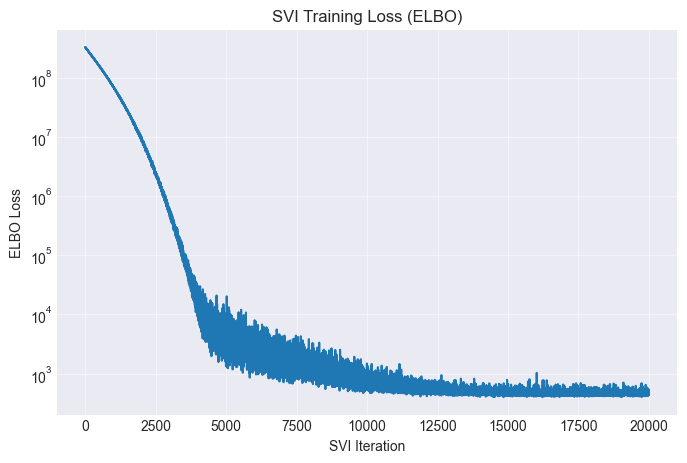

In [29]:
# --- SVI Training ---
rng_key = random.PRNGKey(1)
num_iterations = 20000  # Adjust as needed (might need more or less)

# Use svi.run for a simple training loop
# Pass the necessary data arguments matching the model signature
svi_result = svi.run(
    rng_key,
    num_iterations,
    progress_bar=True,
)

# --- Visualization 1: Training Loss ---
plt.figure(figsize=(8, 5))
plt.plot(svi_result.losses)
plt.xlabel("SVI Iteration")
plt.ylabel("ELBO Loss")
plt.title("SVI Training Loss (ELBO)")
plt.yscale("log")  # Log scale is often useful for ELBO
plt.grid(True, alpha=0.5)
plt.show()


SVI posterior sample keys: dict_keys(['beta0', 'mu_y', 'p', 'sigma', 'tau_g', 'w_m', 'x_true'])


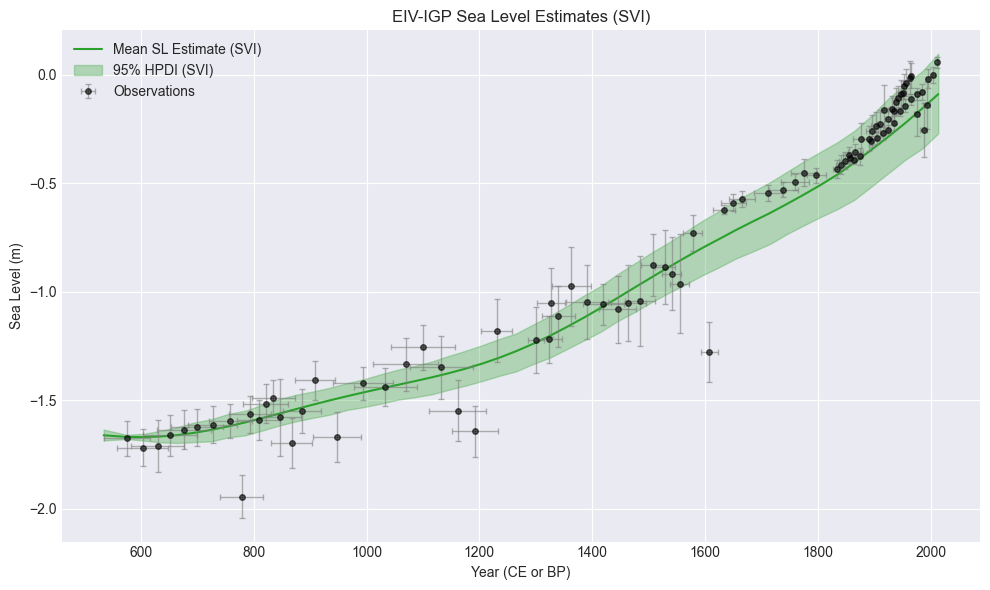

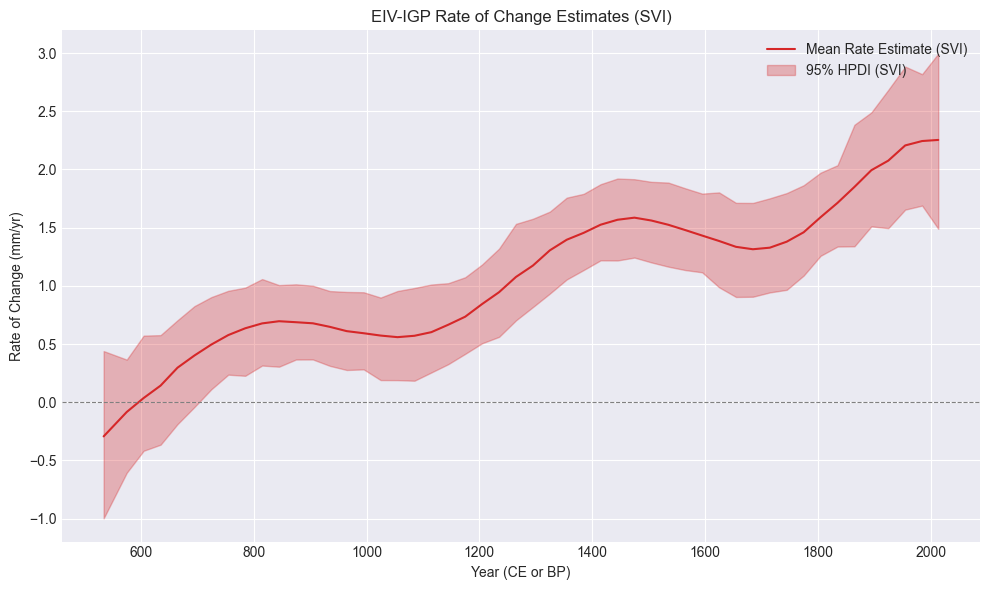

In [30]:
# --- Post-SVI Sampling ---
# Get samples from the learned approximate posterior (the guide)
num_posterior_samples = 1000  # Number of samples to draw for analysis
rng_key, sample_key = random.split(rng_key)

# Get posterior predictive samples from the guide
# svi_params = guide.get_params(svi_result.params) # Alternative way to get params
svi_posterior_samples = guide.sample_posterior(
    sample_key, svi_result.params, sample_shape=(num_posterior_samples,)
)

print("\nSVI posterior sample keys:", svi_posterior_samples.keys())
# Note: SVI samples parameters in their constrained space by default.
# They might have names like 'p_auto_latent'

# --- Visualization 2: Posterior Fit ---
# We need the same post-processing as for MCMC to get SL/Rates on grid


# Define the post-processing function (re-using from MCMC example)
def calculate_grid_sl_svi(
    p_i,
    tau_g_i,
    beta0_i,
    w_m_i,
    Dist_static,
    kappa_static,
    Ngrid_static,
    quad1_grid_jnp_static,
    quad2_grid_jnp_static,
):
    K_unscaled = jnp.zeros((Ngrid_static, Ngrid_static))
    K_unscaled = K_unscaled.at[jnp.diag_indices(Ngrid_static)].set(1 + 1e-5)
    i_idx, j_idx = jnp.triu_indices(Ngrid_static, k=1)
    triu_values = p_i ** ((Dist_static[i_idx, j_idx]) ** kappa_static)
    K_unscaled = K_unscaled.at[i_idx, j_idx].set(triu_values)
    K_unscaled = K_unscaled.at[j_idx, i_idx].set(triu_values)
    try:
        L_unscaled = jax.scipy.linalg.cholesky(K_unscaled, lower=True)
        K_unscaled_inv = jax.scipy.linalg.cho_solve(
            (L_unscaled, True), jnp.eye(Ngrid_static)
        )
    except jnp.linalg.LinAlgError:
        K_unscaled_inv = jnp.linalg.pinv(K_unscaled)
    K_gw_grid = jnp.sum(p_i**quad1_grid_jnp_static * quad2_grid_jnp_static, axis=2)
    mu_y_grid_gp = jnp.matmul(K_gw_grid, jnp.matmul(K_unscaled_inv, w_m_i))
    mu_y_grid = beta0_i + mu_y_grid_gp
    return mu_y_grid


# Prepare static inputs for vmap
Dist_static = jnp.array(Dist)
quad1_grid_jnp_static = jnp.array(
    quad1_grid
)  # Assuming quad1_grid was calculated earlier
quad2_grid_jnp_static = jnp.array(
    quad2_grid
)  # Assuming quad2_grid was calculated earlier

# Vectorize the function
vmap_calculate_grid_sl_svi = jax.vmap(
    lambda p, tg, b0, wm: calculate_grid_sl_svi(
        p,
        tg,
        b0,
        wm,
        Dist_static,
        kappa,
        Ngrid,
        quad1_grid_jnp_static,
        quad2_grid_jnp_static,
    )
)

# Apply to SVI posterior samples
# Need to access the correct keys from svi_posterior_samples
# Use guide.median(svi_result.params) or inspect keys if unsure
svi_post_p = svi_posterior_samples["p"]
svi_post_tau_g = svi_posterior_samples["tau_g"]
svi_post_beta0 = svi_posterior_samples["beta0"]
svi_post_w_m = svi_posterior_samples["w_m"]

svi_posterior_mu_y_grid = vmap_calculate_grid_sl_svi(
    svi_post_p, svi_post_tau_g, svi_post_beta0, svi_post_w_m
)
svi_posterior_rates_grid = svi_post_w_m  # Rates are directly w_m

# --- Calculate summary statistics for SVI results ---
mean_sl_grid_svi = jnp.mean(svi_posterior_mu_y_grid, axis=0)
hpdi_sl_grid_95_svi = numpyro.diagnostics.hpdi(
    svi_posterior_mu_y_grid, prob=0.95, axis=0
)

mean_rates_grid_svi = jnp.mean(svi_posterior_rates_grid, axis=0)
hpdi_rates_grid_95_svi = numpyro.diagnostics.hpdi(
    svi_posterior_rates_grid, prob=0.95, axis=0
)

# --- Plotting SVI results (similar to MCMC plotting) ---

# Get plotting coordinates (ensure min_x_kyear_original is defined)
try:
    min_x_kyear_original = min(df["x"] / 1000)
    x_plot = (x_star + min_x_kyear_original) * 1000
    x_orig_plot = (D[:, 0] + min_x_kyear_original) * 1000
    y_orig_plot = D[:, 1]
    x_err_orig_plot = jnp.sqrt(V[:, 0, 0]) * 1000
    y_err_orig_plot = jnp.sqrt(V[:, 1, 1])
except NameError:
    print("Warning: Plotting against relative x_star.")
    x_plot = x_star
    x_orig_plot = D[:, 0]
    y_orig_plot = D[:, 1]
    x_err_orig_plot = jnp.sqrt(V[:, 0, 0])
    y_err_orig_plot = jnp.sqrt(V[:, 1, 1])

# Plot 1: Sea Level Estimates (SVI)
fig3, ax3 = plt.subplots(figsize=(10, 6))
ax3.plot(x_plot, mean_sl_grid_svi, label="Mean SL Estimate (SVI)", color="C2")
ax3.fill_between(
    x_plot,
    hpdi_sl_grid_95_svi[0],
    hpdi_sl_grid_95_svi[1],
    alpha=0.3,
    color="C2",
    label="95% HPDI (SVI)",
)
ax3.errorbar(
    x_orig_plot,
    y_orig_plot,
    yerr=y_err_orig_plot,
    xerr=x_err_orig_plot,
    fmt="o",
    markersize=4,
    alpha=0.6,
    color="black",
    ecolor="gray",
    elinewidth=1,
    capsize=2,
    label="Observations",
)
ax3.set_xlabel("Year (CE or BP)")
ax3.set_ylabel("Sea Level (m)")
ax3.set_title("EIV-IGP Sea Level Estimates (SVI)")
ax3.legend()
plt.tight_layout()
plt.show()

# Plot 2: Rate Estimates (SVI)
fig4, ax4 = plt.subplots(figsize=(10, 6))
ax4.plot(x_plot, mean_rates_grid_svi, label="Mean Rate Estimate (SVI)", color="C3")
ax4.fill_between(
    x_plot,
    hpdi_rates_grid_95_svi[0],
    hpdi_rates_grid_95_svi[1],
    alpha=0.3,
    color="C3",
    label="95% HPDI (SVI)",
)
ax4.axhline(0, linestyle="--", color="gray", linewidth=0.8)
ax4.set_xlabel("Year (CE or BP)")
ax4.set_ylabel("Rate of Change (mm/yr)")
ax4.set_title("EIV-IGP Rate of Change Estimates (SVI)")
ax4.legend()
plt.tight_layout()
plt.show()
